# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

c:\Users\mahmo\anaconda3\envs\Data-Science\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Overview

## Portfolio

In [2]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Convert the channels column to multiple boolean columns

In [3]:
portfolio_df = portfolio.copy()

In [4]:
portfolio_df['channels'].dtype

dtype('O')

In [5]:
portfolio_df['channels'] = portfolio_df['channels'].astype(str)
portfolio_df['channels'].unique()

array(["['email', 'mobile', 'social']",
       "['web', 'email', 'mobile', 'social']",
       "['web', 'email', 'mobile']", "['web', 'email']"], dtype=object)

From the above analysis it appears that we have 4 unique channels which are web, email, mobile and social

In [6]:
vals_dict = {
    'email': [],
    'mobile': [],
    'web': [],
    'social': []
}

In [7]:
for i in range(len(portfolio_df)):
    channels_lst = portfolio_df.loc[i, 'channels']
    for channel in vals_dict.keys():
        if channel in channels_lst:
            vals_dict[channel].append(True)
        else:
            vals_dict[channel].append(False)

In [8]:
temp_df = pd.DataFrame(vals_dict)
temp_df.head(5)

,email,mobile,web,social
0,True,True,False,True
1,True,True,True,True
2,True,True,True,False
3,True,True,True,False
4,True,False,True,False


In [9]:
portfolio_df = pd.concat([portfolio_df, temp_df], axis=1)
portfolio_df.head(5)

,reward,channels,difficulty,duration,offer_type,id,email,mobile,web,social
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,True,True,False,True
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,True,True,True,True
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,True,True,True,False
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True,False
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,True,False


In [10]:
portfolio_df = portfolio_df.drop('channels', axis=1)

In [11]:
portfolio_df = portfolio_df.set_index('id')
portfolio_df.head(10)

,reward,difficulty,duration,offer_type,email,mobile,web,social
id,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,True,True,False,True
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,True,True,True,True
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,True,True,True,False
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,True,True,True,False
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,True,False,True,False
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,True,True,True,True
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,True,True,True,True
5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,True,True,False,True
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,True,True,True,True


## Transcript

In [12]:
print(transcript.shape)
transcript.head()

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
unique_persons = transcript.loc[:, 'person'].unique()
t_df = transcript.groupby('person')
max_person_id = unique_persons[t_df.size().argmax()]
t_df.get_group(max_person_id)

,person,event,value,time
9942,0200f61c69da4c2ea078842cdaf234e6,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
29175,0200f61c69da4c2ea078842cdaf234e6,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},42
40495,0200f61c69da4c2ea078842cdaf234e6,transaction,{'amount': 15.67},90
40496,0200f61c69da4c2ea078842cdaf234e6,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,90
63138,0200f61c69da4c2ea078842cdaf234e6,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168
74251,0200f61c69da4c2ea078842cdaf234e6,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},180
90198,0200f61c69da4c2ea078842cdaf234e6,transaction,{'amount': 23.74},228
90199,0200f61c69da4c2ea078842cdaf234e6,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,228
94785,0200f61c69da4c2ea078842cdaf234e6,transaction,{'amount': 25.89},246
120794,0200f61c69da4c2ea078842cdaf234e6,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336


In [14]:
val_dict = {
    'offer_id': [],
    'amount' : []
}
for i in range(len(transcript)):
    temp = dict(transcript.loc[i, 'value'])
    key = list(temp.keys())[0]
    val = temp[key]
    if key == 'offer id' or key == 'offer_id':
        val_dict['offer_id'].append(val)
        val_dict['amount'].append(None)
    else:
        val_dict['offer_id'].append(None)
        val_dict['amount'].append(val)

temp_df = pd.DataFrame(val_dict)

In [15]:
transcript_df = pd.concat([transcript, temp_df] , axis=1)
transcript_df = transcript_df.drop('value', axis=1)
transcript_df.head(5)

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [16]:
transcript_df = transcript_df.reset_index()
transcript_df.head(5)

,index,person,event,time,offer_id,amount
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [17]:
unique_persons = transcript_df.loc[:, 'person'].unique()
t_df = transcript_df.groupby('person')
max_person_id = unique_persons[t_df.size().argmax()]
t_df.get_group(max_person_id)


,index,person,event,time,offer_id,amount
9942,9942,0200f61c69da4c2ea078842cdaf234e6,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
29175,29175,0200f61c69da4c2ea078842cdaf234e6,offer viewed,42,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
40495,40495,0200f61c69da4c2ea078842cdaf234e6,transaction,90,None,15.67
40496,40496,0200f61c69da4c2ea078842cdaf234e6,offer completed,90,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
63138,63138,0200f61c69da4c2ea078842cdaf234e6,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
74251,74251,0200f61c69da4c2ea078842cdaf234e6,offer viewed,180,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
90198,90198,0200f61c69da4c2ea078842cdaf234e6,transaction,228,None,23.74
90199,90199,0200f61c69da4c2ea078842cdaf234e6,offer completed,228,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
94785,94785,0200f61c69da4c2ea078842cdaf234e6,transaction,246,None,25.89
120794,120794,0200f61c69da4c2ea078842cdaf234e6,offer received,336,2906b810c7d4411798c6938adc9daaa5,NaN


Get a dataframe of completed offers only to design a classifier that predicts whether or not a person might complete an offer

In [18]:
# df_completed

## Profile

In [19]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [20]:

profile.describe(include='all')

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


Convert became_member_on to year, month, date

In [21]:
profile_df = profile.copy()

In [22]:
profile_df['became_member_on'] = profile_df['became_member_on'].astype(str)
print(profile_df['became_member_on'].dtype)
def change_date_format(date_str):
    out_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
    return out_str

profile_df['became_member_on'] = profile_df['became_member_on'].apply(change_date_format)

object


In [23]:
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], infer_datetime_format=True)

In [24]:
profile_df['became_member_on_year'] = pd.DatetimeIndex(profile_df['became_member_on']).year
profile_df['became_member_on_month'] = pd.DatetimeIndex(profile_df['became_member_on']).month
profile_df['became_member_on_day'] = pd.DatetimeIndex(profile_df['became_member_on']).day
profile_df = profile_df.drop('became_member_on', axis=1)

In [25]:
profile_df.head(10)

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,2017,9,25
7,None,118,68617ca6246f4fbc85e91a2a49552598,NaN,2017,10,2
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
9,None,118,8974fc5686fe429db53ddde067b88302,NaN,2016,11,22


In [26]:
profile_df.describe(include='all')

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
count,14825,17000.000000,17000,14825.000000,17000.000000,17000.000000,17000.000000
unique,3,NaN,17000,NaN,NaN,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN
freq,8484,NaN,1,NaN,NaN,NaN,NaN
mean,NaN,62.531412,NaN,65404.991568,2016.635000,6.683529,15.881176
std,NaN,26.738580,NaN,21598.299410,1.177624,3.487098,8.775390
min,NaN,18.000000,NaN,30000.000000,2013.000000,1.000000,1.000000
25%,NaN,45.000000,NaN,49000.000000,2016.000000,4.000000,8.000000
50%,NaN,58.000000,NaN,64000.000000,2017.000000,7.000000,16.000000
75%,NaN,73.000000,NaN,80000.000000,2017.000000,10.000000,23.000000


It is clear from the above description that:
- 2175 users haven't specified their age.
- 2175 users haven't specified their income (still don't know if they are the same as the ones who didn't specify their age)
- We have users that became members in the region from 2013 to 2018, I can try to derive info such as if the user being older has an effect on whether or not he might accept the offer.


In [27]:
temp_df = profile_df.loc[:, ['age', 'income']]
temp_df = temp_df[temp_df['age'].notna()]
temp_df = temp_df[temp_df['income'].notna()]
temp_df.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


In [28]:
temp_df['age'] = temp_df['age'].astype('category')
temp_df.describe(include='all')

,age,income
count,14825.0,14825.000000
unique,84.0,NaN
top,58.0,NaN
freq,408.0,NaN
mean,NaN,65404.991568
std,NaN,21598.299410
min,NaN,30000.000000
25%,NaN,49000.000000
50%,NaN,64000.000000
75%,NaN,80000.000000


Text(0.5, 1.0, 'age vs income')

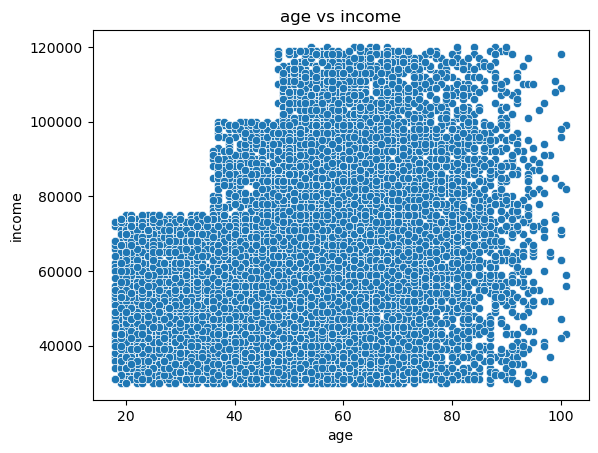

In [29]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=temp_df.age, y=temp_df.income)
ax.set_title('age vs income')

from the above plot we can divide the people into three categories based on the age and income of different users
- below 40
- between 40 and 50
- above 60

In [30]:
def categorize_users(age):
    if age <= 40:
        return '<=40'
    elif age > 40 and age <= 50:
        return '40-50'
    else: 
        return '>50'

In [31]:
temp_df['age_category'] = temp_df['age'].apply(categorize_users)
temp_df.describe(include='all')

,age,income,age_category
count,14825.0,14825.000000,14825
unique,84.0,NaN,3
top,58.0,NaN,>50
freq,408.0,NaN,9132
mean,NaN,65404.991568,NaN
std,NaN,21598.299410,NaN
min,NaN,30000.000000,NaN
25%,NaN,49000.000000,NaN
50%,NaN,64000.000000,NaN
75%,NaN,80000.000000,NaN


get the average income for each group and set it to the clients with None groups

In [32]:
avg_incomes = pd.Series(temp_df.groupby('age_category').income.mean())

In [33]:
def impute_income(row):
    age = row['age']
    income = row['income']
    if pd.isna(income):
        if age <= 40:
            return avg_incomes['<=40']
        elif age > 40 and age <= 50:
            return avg_incomes['40-50']
        else:
            return avg_incomes['>50']
    else:
        return income

In [34]:
profile_df['income'] = profile_df.apply(impute_income, axis=1)

In [35]:
profile_df.describe(include='all')

,gender,age,id,income,became_member_on_year,became_member_on_month,became_member_on_day
count,14825,17000.000000,17000,17000.000000,17000.000000,17000.000000,17000.000000
unique,3,NaN,17000,NaN,NaN,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN
freq,8484,NaN,1,NaN,NaN,NaN,NaN
mean,NaN,62.531412,NaN,66069.420094,2016.635000,6.683529,15.881176
std,NaN,26.738580,NaN,20243.750515,1.177624,3.487098,8.775390
min,NaN,18.000000,NaN,30000.000000,2013.000000,1.000000,1.000000
25%,NaN,45.000000,NaN,51000.000000,2016.000000,4.000000,8.000000
50%,NaN,58.000000,NaN,68000.000000,2017.000000,7.000000,16.000000
75%,NaN,73.000000,NaN,76000.000000,2017.000000,10.000000,23.000000
